# 1. Number of Facilities per 100k Across the US (Interactive)

In [1]:
# Import nessesary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.features import GeoJson, GeoJsonTooltip, CustomIcon
import io
import base64
from matplotlib import cm
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import textwrap

In [ ]:
# Load facility and population data
nmhss2020 = pd.read_csv('nmhss-2020.csv')
population_data = pd.read_csv('population_data.csv')

In [3]:
# Define facility type mapping 
facility_type_mapping = {
    1: 'Psychiatric hospital',
    2: 'Separate inpatient psychiatric unit of a general hospital',
    3: 'Residential treatment center for children',
    4: 'Residential treatment center for adults',
    5: 'Other type of residential treatment facility',
    6: 'Veterans Administration Medical Center',
    7: 'Community Mental Health Center',
    8: 'Certified Community Behavioral Health Clinic',
    9: 'Partial hospitalization/day treatment facility',
    10: 'Outpatient mental health facility',
    11: 'Multi-setting mental health facility',
    12: 'Other'
}

In [4]:
# Define the combined categories for facilites
combined_facility_types = {
    'Inpatient Psychiatric Facility': [1, 2],
    'Residential Treatment Facility': [3, 4, 5],
    'Community-Based Mental Health Center': [7, 8],
    'Outpatient/Day Treatment Facility': [9, 10],
    'Veterans Administration Medical Center': [6],
    'Multi-setting Mental Health Facility and Other': [11, 12]}

In [5]:
# Map facility types to combined categories
def map_facility_type(facility_code):
    for category, codes in combined_facility_types.items():
        if facility_code in codes:
            return category

# Apply the mapping to create a new combined category column
nmhss2020['Combined_Facility_Type'] = nmhss2020['FACILITYTYPE'].map(map_facility_type)

In [6]:
# Count facilities per state
facility_counts = nmhss2020['LST'].value_counts().reset_index()
facility_counts.columns = ['State', 'Facility_Count']

In [7]:
# Transpose population data to have 'State' and 'Population' columns
population_data = population_data.T.reset_index()
population_data.columns = ['State', 'Population']
population_data = population_data[1:] 

In [8]:
# Define a dictionary to map state names to postal codes
state_name_to_code = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI',
    'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'Puerto Rico': 'PR'
}

In [9]:
# Standardize state names and map to postal codes
population_data['State'] = population_data['State'].str.strip().str.title().map(state_name_to_code)
population_data['Population'] = population_data['Population'].str.replace(',', '').astype(float)

In [10]:
# Merge facility counts with population data and calculate facilities per 100,000 people
facility_counts = facility_counts.merge(population_data, on='State', how='left')
facility_counts['Facilities_Per_100k'] = (facility_counts['Facility_Count'] / facility_counts['Population']) * 100000

In [11]:
# Load and prepare US map data, removing Alaska and Hawaii for visualization
us_map = gpd.read_file("ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp")
us_map = us_map[~us_map['name'].isin(['Alaska', 'Hawaii'])]
us_map['State'] = us_map['name'].apply(lambda x: state_name_to_code.get(x))
map_data = us_map.merge(facility_counts, on='State', how='left')

In [12]:
# Create base Folium map with facilities per 100,000 people choropleth
map_data = map_data.to_crs(epsg=4326)
colors = [cm.Paired(i) for i in range(12)]  
m = folium.Map(location=[37.8, -96], zoom_start=4, tiles='cartodbpositron')
folium.Choropleth(
    geo_data=map_data,
    name="choropleth",
    data=map_data,
    columns=["State", "Facilities_Per_100k"],
    key_on="feature.properties.State",
    fill_color="Blues",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Facilities per 100,000 People by State",
).add_to(m)

In [13]:
# Add tooltip with facility information
GeoJson(
    map_data,
    style_function=lambda feature: {
        'fillColor': 'grey',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.1,
    },
    tooltip=GeoJsonTooltip(
        fields=['name', 'Facilities_Per_100k', 'Facility_Count', 'Population'],
        aliases=['State:', 'Facilities per 100k:', 'Facility Count:', 'Population:'],
        localize=True
    )
).add_to(m)

In [14]:
# Add horizontal bar chart for each state using the combined facility types
for idx, row in map_data.iterrows():
    state_name = row['name']
    facility_data_state = nmhss2020[nmhss2020['LST'] == row['State']]
    combined_facility_types_counts = facility_data_state['Combined_Facility_Type'].value_counts()

    # Sort the data in descending order
    combined_facility_types_counts = combined_facility_types_counts.sort_values(ascending=False)

    # Wrap long facility names
    wrapped_labels = [
        "\n".join(textwrap.wrap(label, width=20)) for label in combined_facility_types_counts.index
    ]

    # Generate a horizontal bar chart
    fig, ax = plt.subplots(figsize=(4, 5)) 
    ax.barh(
        wrapped_labels,
        combined_facility_types_counts.values,
        color='darkblue'
    )
    ax.set_title(f"Facility Types in {state_name}", fontsize=14)
    ax.set_xlabel("Counts", fontsize=12)
    ax.set_ylabel("Facility Types", fontsize=12)
    ax.invert_yaxis()  
    plt.tight_layout()

    # Save the horizontal bar chart to a BytesIO object
    bar_img = io.BytesIO()
    plt.savefig(bar_img, format='png', bbox_inches="tight", pad_inches=0.1)  
    plt.close(fig)
    bar_img.seek(0)
    bar_img_base64 = base64.b64encode(bar_img.getvalue()).decode('utf-8')
    bar_img_html = f'<img src="data:image/png;base64,{bar_img_base64}" width="350" height="350">' 

    # Add popup with the horizontal bar chart for each state
    folium.Marker(
        location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
        icon=None,
        popup=folium.Popup(html=bar_img_html, max_width=350)
    ).add_to(m)

In [15]:
# Save the interactive map to an HTML file
m.save("Facilities_per_100k_bar.html")

# 2. Facility Types by Region

In [16]:
# State-to-region mapping
state_region_mapping = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

In [17]:
# Map states to regions
def map_state_to_region(state):
    for region, states in state_region_mapping.items():
        if state in states:
            return region 

In [18]:
# Calculate facilities per 100,000 by region and facility type
nmhss2020['Region'] = nmhss2020['LST'].apply(map_state_to_region)
nmhss2020['FACILITY_COUNT'] = 1

In [19]:
# Group data by Region and Combined Facility Type, summing facility counts
regional_facility_counts = nmhss2020.groupby(['Region', 'Combined_Facility_Type'])['FACILITY_COUNT'].sum().unstack(fill_value=0)

# Add regional populations
region_population = population_data.copy()
region_population['Region'] = region_population['State'].apply(map_state_to_region)
region_population = region_population.groupby('Region')['Population'].sum().reset_index()

In [20]:
# Merge regional facility data with population data
regional_facility_counts['Total_Population'] = region_population.set_index('Region')['Population']
for col in regional_facility_counts.columns[:-1]: 
    regional_facility_counts[col] = (regional_facility_counts[col] / regional_facility_counts['Total_Population']) * 100000

In [21]:
# Drop the 'Total_Population' column after computation
regional_facility_counts.drop(columns='Total_Population', inplace=True)

# Sort regions by total facilities per 100k
regional_facility_counts['Total'] = regional_facility_counts.sum(axis=1)
regional_facility_counts_sorted = regional_facility_counts.sort_values(by='Total', ascending=False)
regional_facility_counts_sorted.drop(columns='Total', inplace=True)

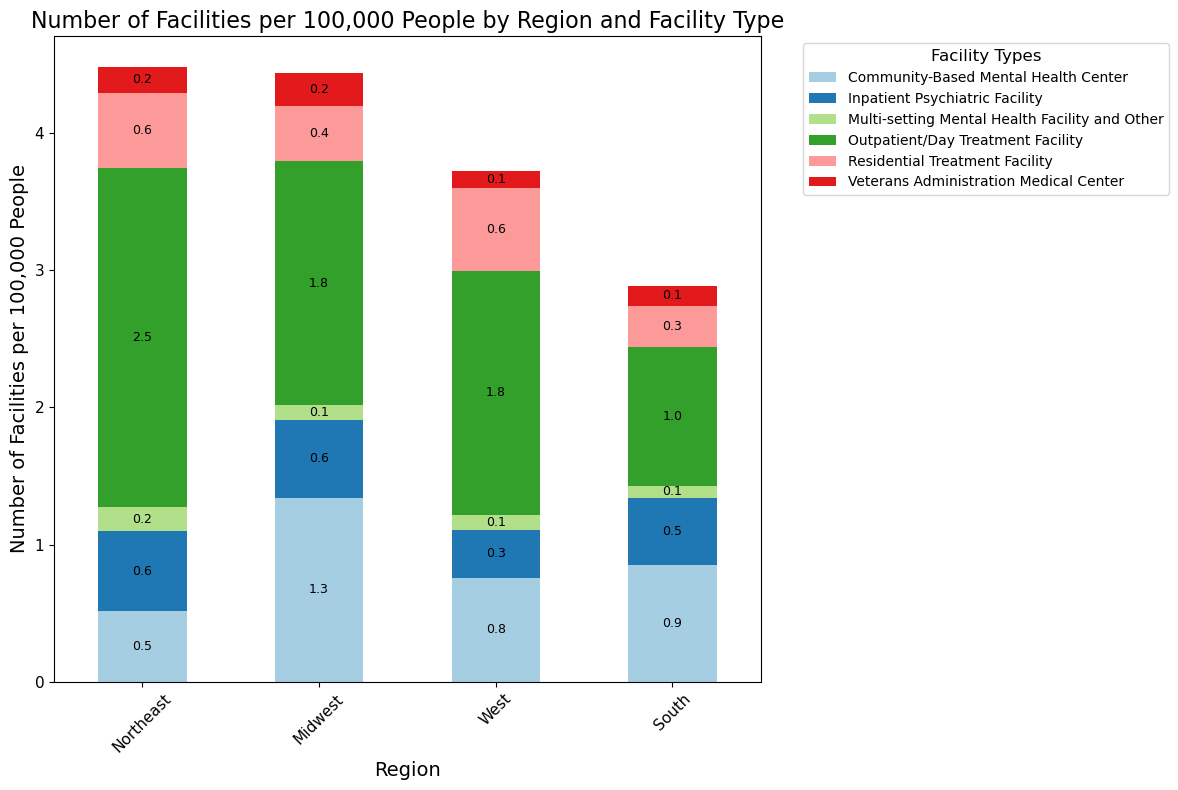

In [22]:
# Plot the stacked bar chart for facilities per 100k people
set2_colors = sns.color_palette("Paired")
ax = regional_facility_counts_sorted.plot(
    kind='bar',
    figsize=(12, 8),
    stacked=True,
    color=set2_colors,
)

# Annotate each stack with the facilities per 100k
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:  
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_y() + height / 2,  
            f"{height:.1f}", 
            ha='center',
            va='center',
            fontsize=9
        )
        
# Customize the labels, title, and legend
plt.xlabel(
    'Region',
    fontsize=14,
    fontfamily='DejaVu Sans'
)
plt.ylabel(
    'Number of Facilities per 100,000 People',
    fontsize=14,
    fontfamily='DejaVu Sans'
)
plt.title(
    'Number of Facilities per 100,000 People by Region and Facility Type',
    fontsize=16,
    fontfamily='DejaVu Sans'
)
plt.xticks(
    rotation=45,
    fontsize=11,
    fontfamily='DejaVu Sans'
)
plt.yticks(
    fontsize=11,
    fontfamily='DejaVu Sans'
)
plt.legend(
    title='Facility Types',
    title_fontsize=12,
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()

# Display the chart
plt.show()


# 3. Therapy Services vs Facility Types

In [23]:
# Import nessesary library
import mpld3 

# Columns to extract: Facility type and various therapy services
relevant_columns = [
    'FACILITYTYPE',  'TREATGRPTHRPY', 
    'TREATCOGTHRPY', 'TREATTRAUMATHRPY', 'TREATACTVTYTHRPY', 'TREATTELEMEDINCE', 
    'LANG'
]

# Extract the relevant columns from the dataset
facility_data_relevant = nmhss2020[relevant_columns]

In [24]:
# Map facility types to their combined category names
facility_data_relevant['Combined Type'] = facility_data_relevant['FACILITYTYPE'].replace(
    {key: category for category, keys in combined_facility_types.items() for key in keys}
)

# Group by the combined facility type and calculate the mean for each service type
grouped_data = facility_data_relevant.groupby('Combined Type').mean()

In [25]:
# Set up a color palette
palette = sns.color_palette("Set1", n_colors=len(grouped_data) + 1) 
palette = [color for color in palette if color != (1.0, 1.0, 0.2)] 

In [26]:
# Renaming columns in the grouped data for readability in the radar chart
grouped_data = grouped_data.rename(columns={
    'TREATGRPTHRPY': 'Group Therapy',
    'TREATCOGTHRPY': 'Cognitive Behavioral Therapy',
    'TREATTRAUMATHRPY': 'Trauma Therapy',
    'TREATACTVTYTHRPY': 'Activity Therapy',
    'TREATTELEMEDINCE': 'Telemedicine',
    'LANG': 'Language Services Other than English'
})

# Redefine categories for plotting
categories = grouped_data.columns[1:]  
num_vars = len(categories)

In [27]:
# Set up angles for each axis on the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  

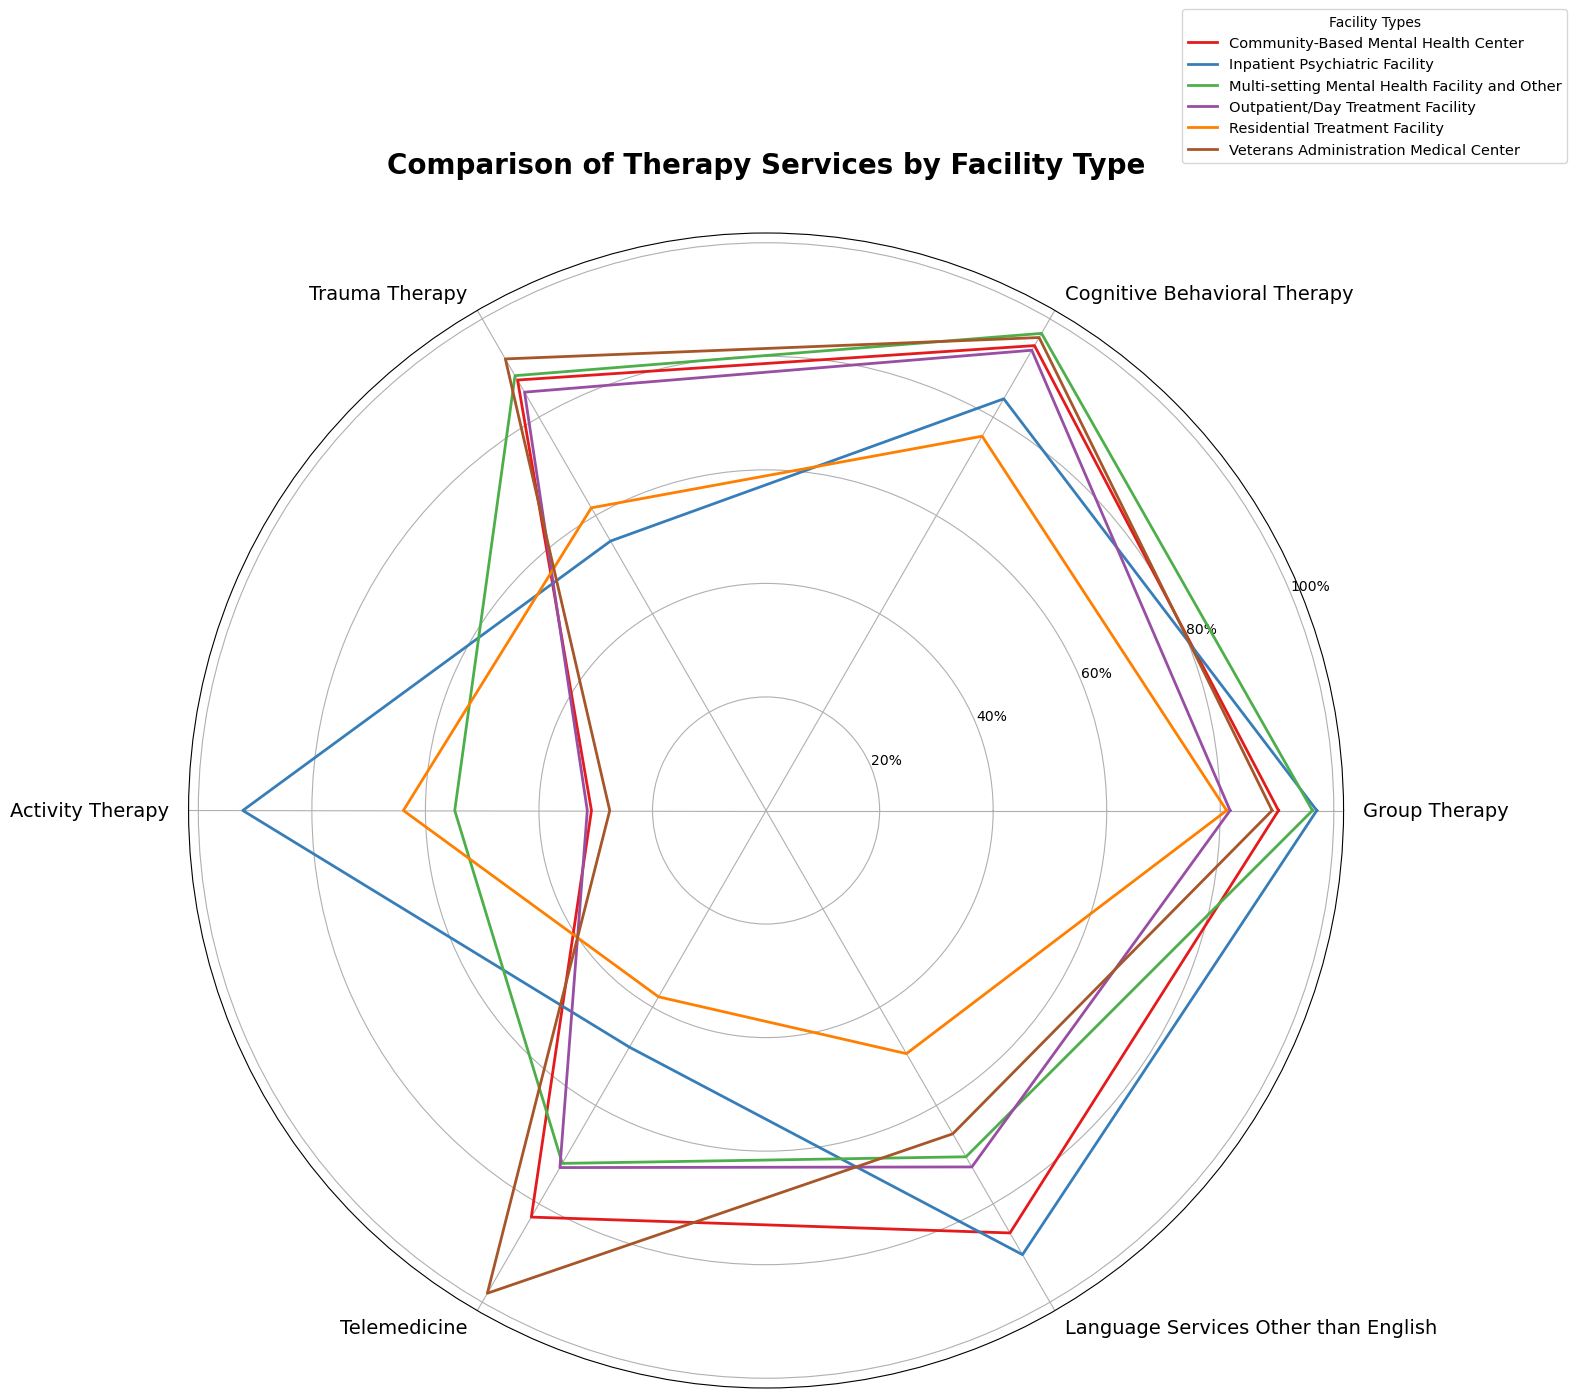

In [28]:
# Create radar chart with updated labels
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(polar=True))

# Loop through each facility type and assign a color from the palette
for i, (facility_type, row) in enumerate(grouped_data.iterrows()):
    values = row[categories].tolist()
    values += values[:1]  
    ax.plot(angles, values, label=facility_type, color=palette[i], linewidth=2) 

# Labels and legend
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])

ax.set_xticks(angles[:-1]) 
ax.set_xticklabels(categories, fontsize=14,fontfamily='DejaVu Sans' )

# Use transform to move the labels outward
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)  
    if angle_deg >= 90 and angle_deg <= 270: 
        label.set_horizontalalignment('right')
    else:  
        label.set_horizontalalignment('left')
    x, y = label.get_position()
    label.set_position((x * 1.2, y * 1.2)) 

# Title and legend
ax.set_title(
    "Comparison of Therapy Services by Facility Type\n  ",
    size=20, weight='bold', pad=20,fontfamily='DejaVu Sans')

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2), fontsize=10.5, title="Facility Types")

# Show the chart
plt.show()

# 4. Treatment Services Offered Trend (2016-2020)

In [29]:
# Import necessary libraries
import pandas as pd
import altair as alt

In [30]:
# Load data from other years
nmhss2019= pd.read_csv("nmhss-2019.csv")
nmhss2018= pd.read_csv("nmhss-2018.csv")
nmhss2017= pd.read_csv("nmhss-2017.csv")
nmhss2016= pd.read_csv("nmhss-2016.csv")
nmhss2017.rename(columns={'caseid': 'CASEID', 'lst': 'LST'}, inplace=True)

In [31]:
# Mapping each year to its corresponding dataset
data_years = {
    2016: nmhss2016,
    2017: nmhss2017,
    2018: nmhss2018,
    2019: nmhss2019,
    2020: nmhss2020
}

In [32]:
# Mapping treatment categories to their corresponding column names
treatment_categories = {
    "Psychotherapy": ['TREATPSYCHOTHRPY', 'TREATGRPTHRPY', 'TREATFAMTHRPY'],
    "Behavioral Therapy": ['TREATBEHAVMOD', 'TREATCOGTHRPY', 'TREATDIALTHRPY'],
    "Trauma and Activity Therapy": ['TREATTRAUMATHRPY', 'TREATACTVTYTHRPY'],
    "Advanced Therapies": ['TREATTELEMEDINCE', 'TREATEMDR', 'TREATKIT', 'TREATTMS', 'TREATELECTRO'],
    "Dual and Cognitive Therapy": ['TREATDUALMHSA', 'TREATCOGREM'],
    "Others":["NOTREAT", "TREATOTH"]
}

In [33]:
# Initialize a list to store aggregated data
aggregated_data = []

# Aggregate facility counts by year and treatment category
for year, data in data_years.items():
    for category_name, columns in treatment_categories.items():
        existing_columns = [col for col in columns if col in data.columns]
        if existing_columns:
            num_facilities = data[existing_columns].sum().sum()
        else:
            num_facilities = 0 
        aggregated_data.append({
            "Year": year,
            "Treatment Category": category_name,
            "Number of Facilities": num_facilities
        })
aggregated_df = pd.DataFrame(aggregated_data)



In [34]:
# Create a line chart to visualize trends in treatment services
chart = alt.Chart(aggregated_df).mark_line(point=True).encode(
    alt.X('Year:O', title='Year'),
    alt.Y('Number of Facilities:Q', title='Number of Facilities'),
    alt.Color('Treatment Category:N'),
).properties(
    title='Trends in Treatment Services Offered by Mental Health Facilities (2016-2020)',
    width=600,
    height=400
)
# Display the chart
chart.show()

alt.Chart(...)

In [35]:
# Save the chart as an HTML file
chart.save("treatment_categories_2016_2020.html")

# 5. Sankey Diagram: Ownership to Treatment to Payment Assistance to Facility Type

In [9]:
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, HTML

# Load the CSV file
csv_path = "aggregated_flows.csv"
data = pd.read_csv(csv_path)

# Extract source, target, and count columns
source = data['Source']  
target = data['Target']  
count = data['Count']    

In [10]:
# Combine unique source and target labels into a single list
all_labels = pd.concat([source, target]).unique()
label_map = {label: idx for idx, label in enumerate(all_labels)}

# Map source and target labels to their indices
source_indices = source.map(label_map)
target_indices = target.map(label_map)

In [11]:
# Calculate percentages for the tooltips
total_flow = count.sum()
percentages = (count / total_flow * 100).round(2).astype(str) + '%'

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=list(all_labels)
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=count,
        customdata=percentages,  # Add custom data for tooltips
        hovertemplate=(
            "Source: %{source.label}<br>"
            "Target: %{target.label}<br>"
            "Value: %{value}<br>"
            "Percentage: %{customdata}<extra></extra>"
        )
    )
)])

In [12]:
# Add title and layout adjustments
fig.update_layout(
    title_text="4-Way Sankey Diagram: Ownership → Treatment → Payment Assistance → Facility Type",
    font=dict(size=12)
)

# Add a legend for facility types
legend_html = """
<div style="margin-top: 20px; padding: 10px; border: 1px solid black; display: inline-block; font-family: Arial, sans-serif; font-size: 12px; background-color: #f9f9f9;">
    <b>Facility Type Legend:</b>
    <div>1: Psychiatric Hospital</div>
    <div>2: Separate inpatient psychiatric unit of a general hospital</div>
    <div>3: Residential treatment center for children</div>
    <div>4: Residential treatment center for adults</div>
    <div>5: Other type of residential treatment facility</div>
    <div>6: Veterans Administration Medical Center (VAMC)</div>
    <div>7: Community Mental Health Center (CMHC)</div>
    <div>8: Certified Community Behavioral Health Clinic (CCBHC)</div>
    <div>9: Partial hospitalization/day treatment facility</div>
    <div>10: Outpatient mental health facility</div>
    <div>11: Multi-setting mental health facility</div>
</div>
"""

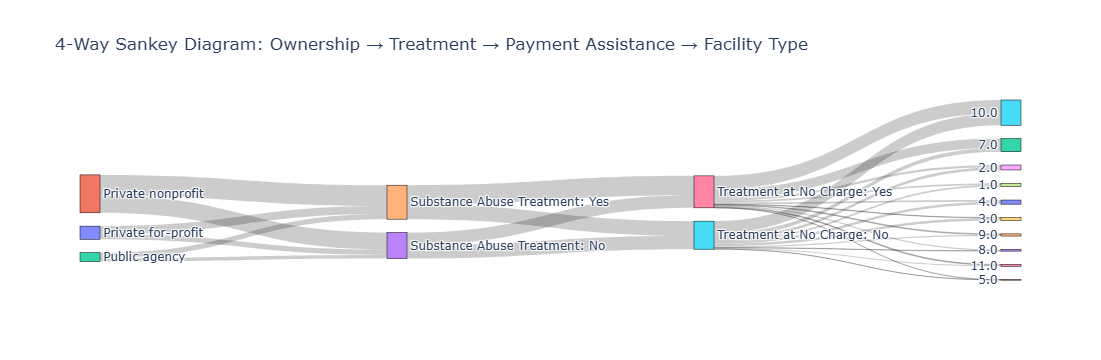

In [13]:
# Display the Sankey diagram
fig.show()

# Display the legend
display(HTML(legend_html))

# 7. Treatments Offered By State

In [8]:
import pandas as pd

data_2020 = pd.read_csv("../nmhss-2020.csv")

# Filter for Treatments
suffixes = ('ANTIPSYCH','_ORAL', '_INJ', '_LAI', '_REC', '_TOP')
temp = data_2020[[col for col in data_2020.columns if col.endswith(suffixes)]]

columns_mapping = {col: col.split('_')[0] for col in temp.columns}
treatments = temp.groupby(columns_mapping, axis=1).max()

# Replace Unknown with Not Acquired
treatments = treatments.replace(-2, 0)

suffixes = ('LST', 'ANTIPSYCH','_ORAL', '_INJ', '_LAI', '_REC', '_TOP')
temp = data_2020[[col for col in data_2020.columns if col.endswith(suffixes)]]

columns_mapping = {col: col.split('_')[0] for col in temp.columns}
treatments_by_state = temp.groupby(columns_mapping, axis=1).max()
treatments_by_state = treatments_by_state.replace(-2, 0)

# Define the drug groups
groups = {
    'Schizophrenia Treatment': ['CHLOR', 'HALOP', 'FLUPH', 'PERPH', 'LOXAP', 'THIOR', 'THIOT', 'TRIFL', 'PIMOZ', 'DROPE', 'PROCH', 'ARIPI', 'ASENA', 'BREXP', 'CARIP', 'CLOZA', 'ILOPE', 'LURAS', 'OLANZ', 'OLANZFLU', 'PALIP', 'QUETI', 'RISPE', 'SECGEN1OTH', 'SECGEN2OTH', 'SECGEN3OTH', 'ZIPRA'],
    'Bipolar Disorder Treatment': ['ARIPI', 'ASENA', 'BREXP', 'CARIP', 'CLOZA', 'ILOPE', 'LURAS', 'OLANZ', 'OLANZFLU', 'PALIP', 'QUETI', 'RISPE', 'SECGEN1OTH', 'SECGEN2OTH', 'SECGEN3OTH', 'ZIPRA'],
    'Psychotic Disorders (Non-Schizophrenic)': ['ARIPI', 'ASENA', 'BREXP', 'CARIP', 'CLOZA', 'RISPE', 'QUETI', 'ZIPRA'],
    'Mood Stabilizers (Mania, Depression)': ['ARIPI', 'LURAS', 'PALIP', 'QUETI', 'RISPE'],
    'Treatment-Resistant or Adjunctive Treatment': ['BREXP', 'CARIP', 'LURAS', 'PALIP'],
    'Adjunctive Antidepressant Use': ['OLANZ', 'OLANZFLU', 'ILOPE']
}

# Store the summed values for each group
summed_groups = {}

for group, drugs in groups.items():
    summed_groups[group] = treatments[drugs].apply(lambda row: 1 if 1 in row.values else 0, axis=1)

summed_df = pd.DataFrame(summed_groups)
summed_df = summed_df.applymap(lambda x: 1 if x > 0 else 0)

# Create a dictionary of drug abbreviations and full names
drug_dict = {
    "ANTIPSYCH": "Antipsychotics",
    "ARIPI": "Aripiprazole",
    "ASENA": "Asenapine",
    "BREXP": "Brexpiprazole",
    "CARIP": "Cariprazine",
    "CHLOR": "Chlorpromazine",
    "CLOZA": "Clozapine",
    "DROPE": "Droperidol",
    "FLUPH": "Fluphenazine",
    "FSTGENOTH": "1st-Gen Antipsychotics (Other)",
    "HALOP": "Haloperidol",
    "ILOPE": "Iloperidone",
    "LOXAP": "Loxapine",
    "LST": "LST",
    "LURAS": "Lurasidone",
    "OLANZ": "Olanzapine",
    "OLANZFLU": "Olanzapine-Fluoxetine",
    "PALIP": "Paliperidone",
    "PERPH": "Perphenazine",
    "PIMOZ": "Pimozide",
    "PROCH": "Prochlorperazine",
    "QUETI": "Quetiapine",
    "RISPE": "Risperidone",
    "SECGEN1OTH": "2nd-Gen Antipsychotics 1",
    "SECGEN2OTH": "2nd-Gen Antipsychotics 2",
    "SECGEN3OTH": "2nd-Gen Antipsychotics 3",
    "THIOR": "Thioridazine",
    "THIOT": "Thiothixene",
    "TRIFL": "Trifluoperazine",
    "ZIPRA": "Ziprasidone"
}

drug_df = pd.DataFrame(list(drug_dict.items()), columns=["Abbreviation", "Full Name"])

# Rename groups to use full names of drugs rather than abbreviations
renamed_groups = {
    group: [drug_dict.get(drug, drug) for drug in drugs]
    for group, drugs in groups.items()
}

C:\Users\junxi\AppData\Local\Temp\ipykernel_1304\3585159517.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  treatments = temp.groupby(columns_mapping, axis=1).max()
C:\Users\junxi\AppData\Local\Temp\ipykernel_1304\3585159517.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  treatments_by_state = temp.groupby(columns_mapping, axis=1).max()
C:\Users\junxi\AppData\Local\Temp\ipykernel_1304\3585159517.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summed_df = summed_df.applymap(lambda x: 1 if x > 0 else 0)


In [12]:
treatments_by_state.to_csv('treatments_by_state.csv', index=False)
print("Treatments by state saved to treatments_by_state.csv")

groups_data = []
for group, drugs in renamed_groups.items():
    groups_data.append({
        'group': group,
        'drugs': ','.join(drugs)
    })

groups_df = pd.DataFrame(groups_data)
groups_df.to_csv('drug_groups.csv', index=False)
print("Drug groups saved to drug_groups.csv")

Treatments by state saved to treatments_by_state.csv
Drug groups saved to drug_groups.csv
